<a href="https://colab.research.google.com/github/RuiyunHuang/Chicago_Crime_Analysis/blob/master/Chicago_Crime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Part 0: Environment Setup**

##**0.1 Install package**


In [1]:
!pip install git+https://github.com/python-visualization/folium

  Cloning https://github.com/python-visualization/folium to /tmp/pip-req-build-9va3va4h
  Running command git clone -q https://github.com/python-visualization/folium /tmp/pip-req-build-9va3va4h
  Created wheel for folium: filename=folium-0.10.1+6.g4a7532d-py2.py3-none-any.whl size=93921 sha256=7fec5f18a9f245d4b100e0c57a607d83adbea6c5c9a62d9861d0bb998c242cdd
  Stored in directory: /tmp/pip-ephem-wheel-cache-le4bgmqr/wheels/1e/e1/75/ecbc91fd5dd5d90befb0b533bf7492d38acffa033310731862
Successfully built folium
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.10.1+6.g4a7532d which is incompatible.
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


##**0.2 Import packages**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import folium as fl
from datetime import datetime

sns.set_palette("husl")
%matplotlib inline

##**0.3 Import data to Colab**

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1hkLBV2uhGO6k_BvV6FsQw2nIFZvLfIW2'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('crime.csv')

# **Part 1: Data Cleaning**

In [0]:
raw_data=pd.read_csv('crime.csv')

In [5]:
raw_data.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10786009,HZ554425,12/16/2016 10:30:00 AM,014XX W 78TH ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,True,False,612,6.0,17.0,71.0,05,1168161.0,1853026.0,2016,01/07/2020 03:50:13 PM,41.752236,-87.659334,"(41.752235645, -87.659334168)"
1,10734627,HZ494078,10/28/2016 02:00:00 PM,002XX E 92ND ST,0610,BURGLARY,FORCIBLE ENTRY,POOL ROOM,False,False,633,6.0,9.0,49.0,05,1179757.0,1844042.0,2016,01/07/2020 03:50:13 PM,41.727325,-87.617114,"(41.72732535, -87.617114114)"
2,11694006,JC267197,01/01/2016 12:01:00 AM,048XX W WABANSIA AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,True,2533,25.0,37.0,25.0,17,NaN,NaN,2016,01/06/2020 03:49:40 PM,NaN,NaN,NaN
3,10613199,HZ366157,07/27/2016 12:49:00 AM,116XX S AVENUE M,0620,BURGLARY,UNLAWFUL ENTRY,RESIDENCE-GARAGE,True,False,433,4.0,10.0,55.0,05,1201591.0,1828417.0,2016,01/06/2020 03:49:40 PM,41.683923,-87.537663,"(41.683922677, -87.53766346)"
4,11940434,JD102754,09/01/2016 08:00:00 AM,059XX S INDIANA AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,232,2.0,20.0,40.0,11,NaN,NaN,2016,01/04/2020 03:46:59 PM,NaN,NaN,NaN


In [0]:
raw_data=raw_data.drop(['ID', 'Case Number', 'Location', 'Updated On', 'X Coordinate', 'Y Coordinate'], axis=1);

In [7]:
raw_data.shape

(1063214, 16)

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063214 entries, 0 to 1063213
Data columns (total 16 columns):
Date                    1063214 non-null object
Block                   1063214 non-null object
IUCR                    1063214 non-null object
Primary Type            1063214 non-null object
Description             1063214 non-null object
Location Description    1058984 non-null object
Arrest                  1063214 non-null bool
Domestic                1063214 non-null bool
Beat                    1063214 non-null int64
District                1063213 non-null float64
Ward                    1063194 non-null float64
Community Area          1063208 non-null float64
FBI Code                1063214 non-null object
Year                    1063214 non-null int64
Latitude                1051982 non-null float64
Longitude               1051982 non-null float64
dtypes: bool(2), float64(5), int64(2), object(7)
memory usage: 115.6+ MB


In [9]:
raw_data.isnull().sum()

Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     4230
Arrest                      0
Domestic                    0
Beat                        0
District                    1
Ward                       20
Community Area              6
FBI Code                    0
Year                        0
Latitude                11232
Longitude               11232
dtype: int64

#**Part 2: Data Exploration**

###**2.1 Find top 10 crimes**

In [10]:
# take a look at all crime categories
raw_data['Primary Type'].unique()

array(['BURGLARY', 'OFFENSE INVOLVING CHILDREN', 'DECEPTIVE PRACTICE',
       'SEX OFFENSE', 'CRIM SEXUAL ASSAULT', 'BATTERY', 'CRIMINAL DAMAGE',
       'THEFT', 'NARCOTICS', 'HOMICIDE', 'ROBBERY', 'OTHER OFFENSE',
       'WEAPONS VIOLATION', 'MOTOR VEHICLE THEFT', 'ASSAULT',
       'PUBLIC PEACE VIOLATION', 'CRIMINAL TRESPASS', 'NON-CRIMINAL',
       'INTERFERENCE WITH PUBLIC OFFICER', 'ARSON',
       'CONCEALED CARRY LICENSE VIOLATION', 'STALKING', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'PROSTITUTION', 'INTIMIDATION',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'OBSCENITY', 'GAMBLING',
       'NON - CRIMINAL', 'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY',
       'HUMAN TRAFFICKING'], dtype=object)

In [0]:
#remove those non-crimes
non_crime=set(['NON - CRIMINAL', 'NON-CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)'])
raw_data=raw_data[~raw_data['Primary Type'].isin(non_crime)]

          Primary Type  Number of crimes
0                THEFT            253284
1              BATTERY            198942
2      CRIMINAL DAMAGE            114594
3              ASSAULT             79064
4   DECEPTIVE PRACTICE             75170
5        OTHER OFFENSE             68323
6            NARCOTICS             52304
7             BURGLARY             48615
8  MOTOR VEHICLE THEFT             41644
9              ROBBERY             41540


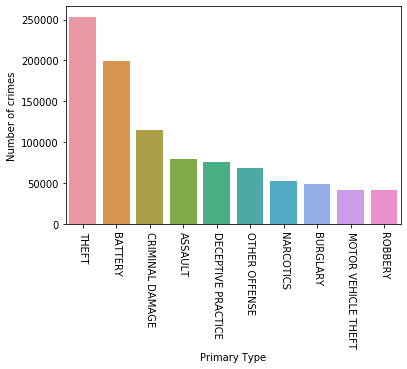

In [12]:
#list top 10 crimes
crime_by_type=raw_data.groupby('Primary Type').size().sort_values(ascending=False).rename('Number of crimes').reset_index().head(10)
print(crime_by_type)
plt.figure()
plt.xticks(rotation=-90)
sns.barplot(x='Primary Type', y='Number of crimes', data=crime_by_type)

###**2.2 List top 10 dangerous districts**

In [13]:
raw_data['District'].unique()

array([ 6., 25.,  4.,  2., 16., 15.,  5.,  7., 20., 14., 19.,  8., 12.,
       22., 10., 17.,  3., 11.,  9., 18., 24.,  1., 31., nan])

  District  Number of crimes
0       11             73960
1        6             65932
2        8             65919
3        1             59903
4       18             59551
5        4             57828
6        7             55844
7       25             54900
8       12             53735
9       10             50073


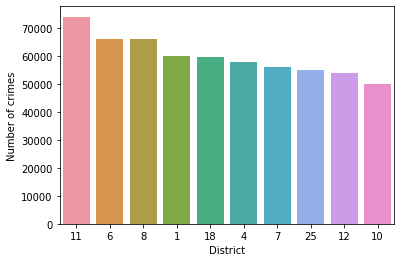

In [14]:
# list top district
crime_by_district=raw_data.groupby('District').size().sort_values(ascending=False).rename('Number of crimes').reset_index().head(10)
crime_by_district['District']=crime_by_district['District'].astype(int).astype(str)
print(crime_by_district)
plt.figure()
sns.barplot(x='District', y='Number of crimes', data=crime_by_district, order=crime_by_district['District'])

###**2.3 Time dependence of crimes**

In [0]:
# parse date 
raw_data['Date']=pd.to_datetime(raw_data['Date'], format='%m/%d/%Y %I:%M:%S %p')
raw_data['Day']=raw_data['Date'].dt.day
raw_data['Month']=raw_data['Date'].dt.month
raw_data['DayofWeek']=raw_data['Date'].dt.dayofweek
raw_data['Hour']=raw_data['Date'].dt.hour

In [0]:
years=[2016, 2017, 2018, 2019]
months_temp=['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']
hour_temp=np.arange(0, 25, 1).tolist()

**By month**

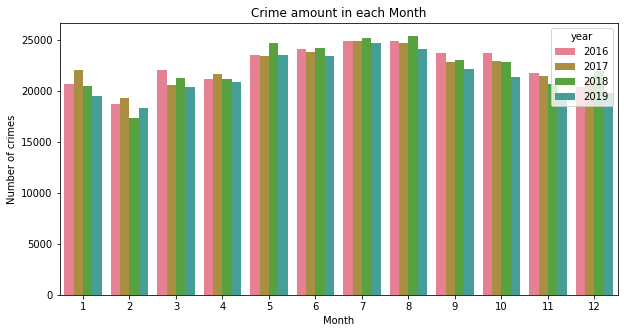

In [17]:
crime_by_Month=pd.DataFrame()
for _ in years:
  tmp=raw_data[raw_data.Year == _].groupby('Month')\
  .size().rename('Number of crimes').reset_index()
  tmp['year']=_
  crime_by_Month=pd.concat([crime_by_Month, tmp])

plt.figure(figsize=[10, 5])
plt.title('Crime amount in each Month')
sns.barplot(x=crime_by_Month.Month, y=crime_by_Month['Number of crimes'], hue=crime_by_Month.year, data=crime_by_Month)

**By day of week**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


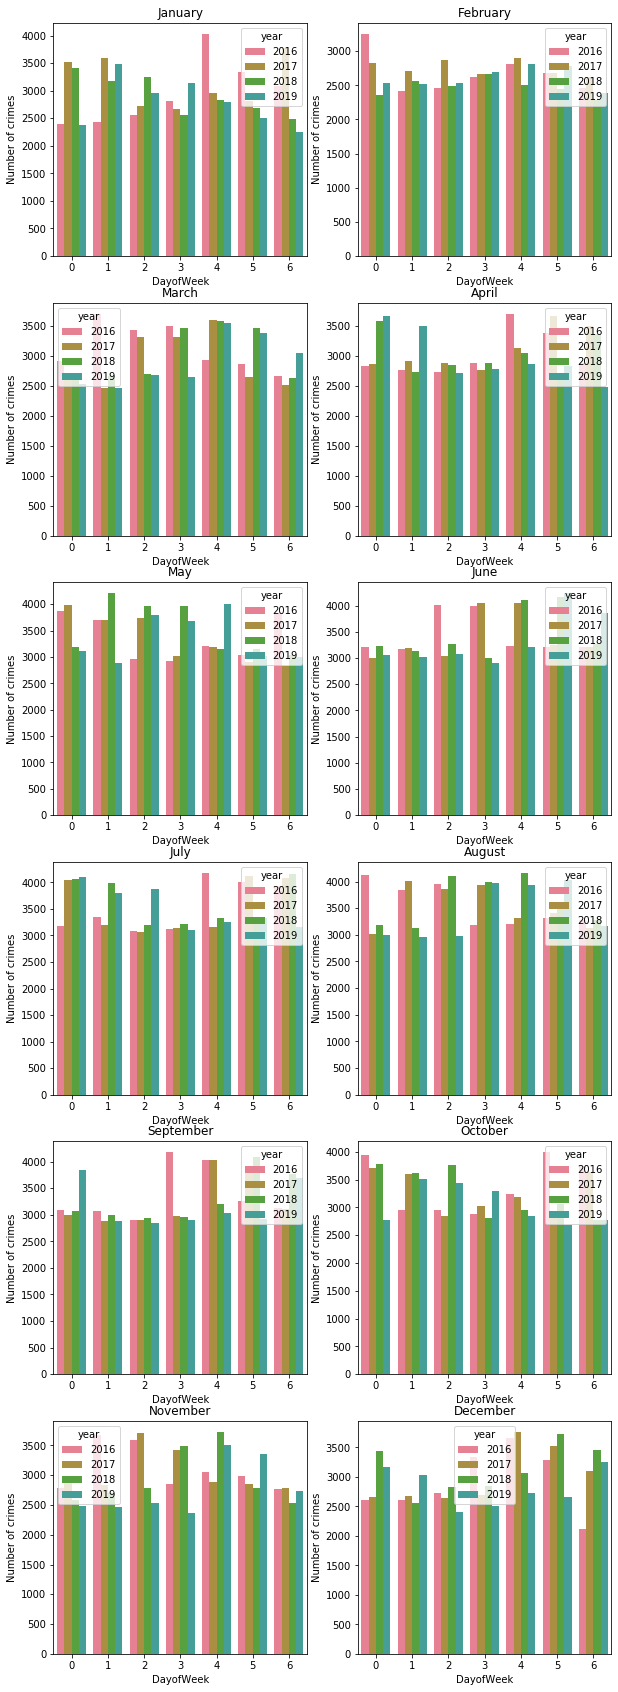

In [18]:
months=np.arange(1, 13, 1)
plt.figure(figsize=[10, 30])
for i in months:
  crime_by_dayofweek=pd.DataFrame()
  tmp=raw_data[(raw_data.Month == i)]
  for j in years:
    tmp_j=tmp[raw_data.Year == j].groupby('DayofWeek')\
    .size().rename('Number of crimes').reset_index()
    tmp_j['year']=j
    crime_by_dayofweek=pd.concat([crime_by_dayofweek, tmp_j])
  plt.subplot(6, 2, i)
  plt.title(months_temp[i-1])
  sns.barplot(x=crime_by_dayofweek.DayofWeek, y=crime_by_dayofweek['Number of crimes'], hue=crime_by_dayofweek.year, data=crime_by_dayofweek)

**By hour**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


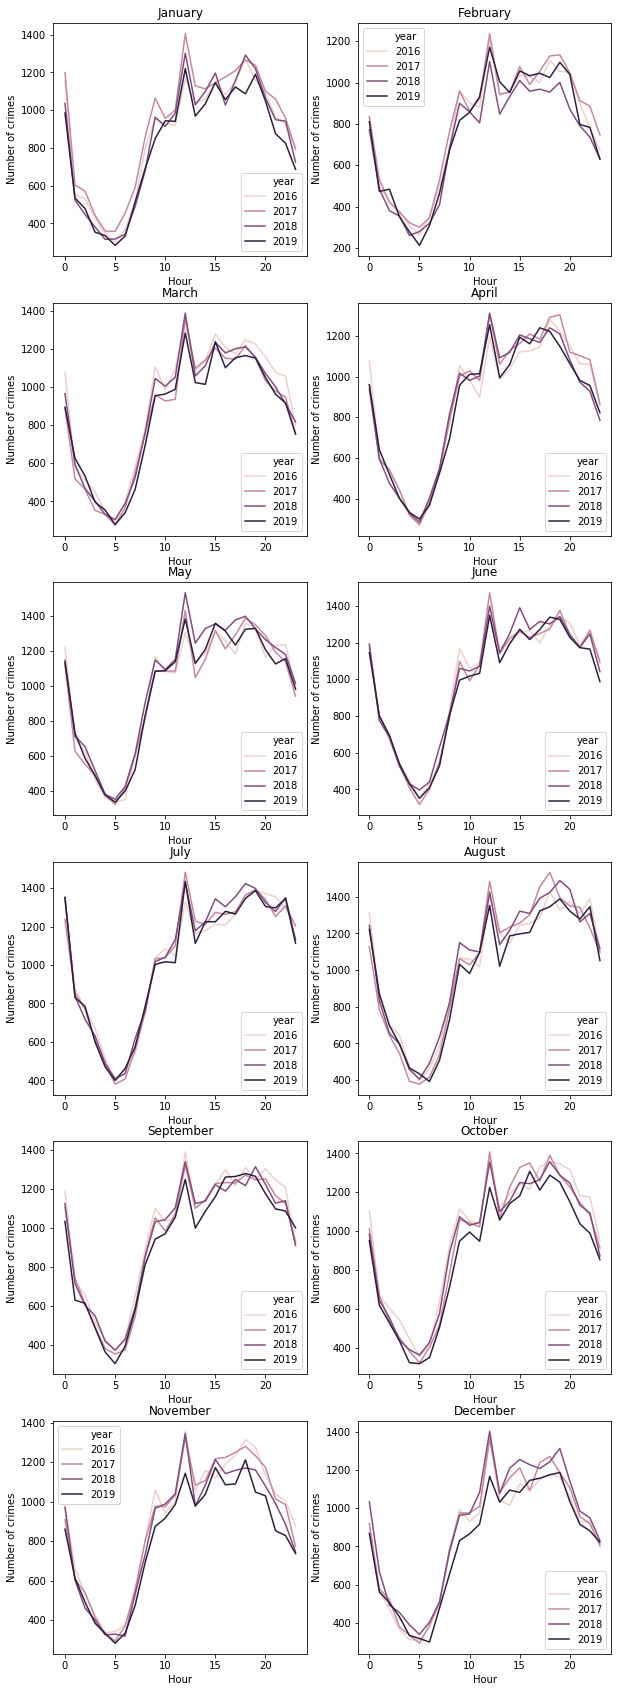

In [19]:
plt.figure(figsize=[10, 30])
for i in months:
  crime_by_hour=pd.DataFrame()
  tmp=raw_data[(raw_data.Month == i)]
  for j in years:
    tmp_j=tmp[raw_data.Year == j].groupby('Hour')\
    .size().rename('Number of crimes').reset_index()
    tmp_j['year']=j
    crime_by_hour=pd.concat([crime_by_hour, tmp_j])
  plt.subplot(6, 2, i)
  plt.title(months_temp[i-1])
  sns.lineplot(x=crime_by_hour.Hour, y=crime_by_hour['Number of crimes'], hue=crime_by_hour.year, data=crime_by_hour)

#**Part 3: Visualization**

In [0]:
chicago_cor=[41.8781, -87.6298]
Time_type='Hour'
Crime_type='ROBBERY'

In [0]:
location_list=raw_data[(~raw_data.Latitude.isnull()) & (raw_data.Year == 2019) & (raw_data['Primary Type'] == Crime_type)][['Latitude', 'Longitude', Time_type]]
location_list['xy']=location_list[['Latitude', 'Longitude']].values.tolist()
location_list=location_list[['xy', Time_type]].groupby(Time_type).agg(list)
lc=location_list['xy'].values.tolist()

In [22]:
from folium.plugins import HeatMapWithTime
chicago_cor=[41.8781, -87.6298]
m = fl.Map(location=chicago_cor, zoom_start=11)
HeatMapWithTime(lc, index=location_list.index.tolist(), radius=10).add_to(m)
m

#**Part 4: Modeling**

##**4.1: K-means clustering on locations**

In [0]:
from sklearn.cluster import KMeans

In [0]:
# set summer as tour months
tour_months=set([6, 7, 8])
train_X = raw_data[(raw_data.Year==2019) & (raw_data.Month.isin(tour_months)) & (raw_data['Primary Type'] == Crime_type)][['Latitude', 'Longitude']].dropna()

In [0]:
def k_means(train, n):
  model=KMeans(n)
  model.fit(train)
  predictions=model.predict(train)
  train['predictions']=predictions
  return train

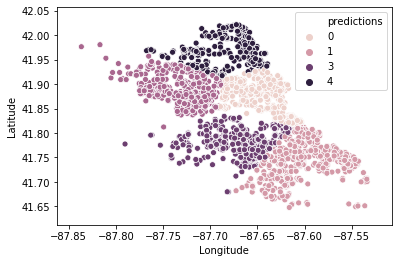

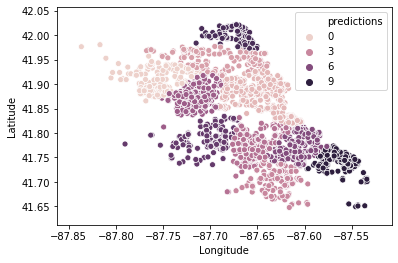

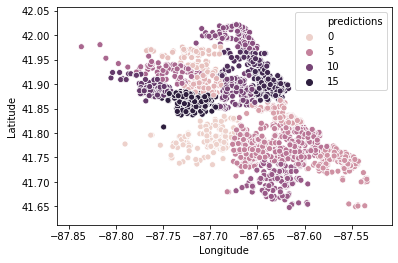

In [26]:
for n in range(5, 20, 5):
  result=k_means(train_X, n)
  plt.figure()
  sns.scatterplot(x=result.Longitude, y=result.Latitude, hue=result.predictions, data=result)
  plt.show()

In [0]:
train_X['xy']=train_X[['Latitude', 'Longitude']].values.tolist()
kmeans_result=train_X[['xy', 'predictions']]

In [0]:
kmeans_result=kmeans_result.groupby('predictions').agg([list, 'count'])


In [0]:
kmeans_result.columns=['xy', 'numbers']

In [30]:
kmeans_result['numbers'].sum()

2312

##**4.2: Time series analysis**

###**4.2.1: Data processing**

In [0]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [0]:
years=[2016, 2017, 2018, 2019]

In [0]:
raw_data['Date_only']=raw_data['Date'].dt.date
train_crime_by_day = raw_data[raw_data['Year'].isin(years)].groupby('Date_only').size().rename('Number of crimes').reset_index()
train_crime_by_day['Date_only']=pd.to_datetime(train_crime_by_day['Date_only'])
train_crime_by_day=train_crime_by_day.set_index('Date_only', drop=True)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


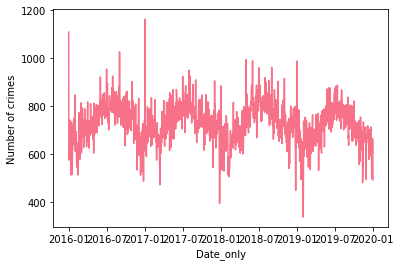

In [34]:
plt.figure()
sns.lineplot(x=train_crime_by_day.index, y=train_crime_by_day['Number of crimes'], data=train_crime_by_day)

###**4.2.2: Seasonal decomposition**

Text(0.5, 0.98, 'Multiplicative Decompose')

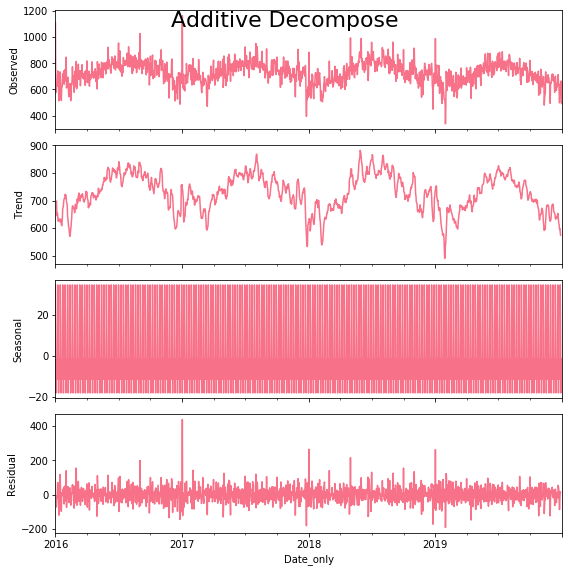

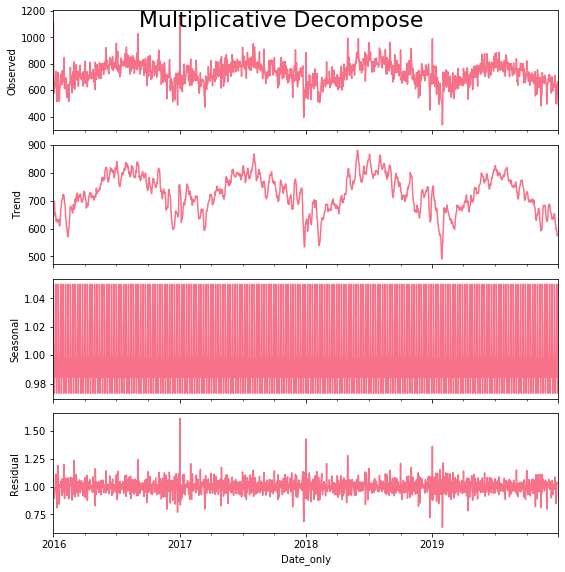

In [35]:
additive=sm.tsa.seasonal_decompose(train_crime_by_day)
multiplicative=sm.tsa.seasonal_decompose(train_crime_by_day, model='multiplicative')

plt.rcParams.update({'figure.figsize': (8,8)})
additive.plot().suptitle('Additive Decompose', fontsize=22)
multiplicative.plot().suptitle('Multiplicative Decompose', fontsize=22)



In [36]:
additive.seasonal.head(14)

,Number of crimes
Date_only,
2016-01-01,34.825583
2016-01-02,13.951269
2016-01-03,-18.004320
2016-01-04,-1.234857
2016-01-05,-11.098181
2016-01-06,-11.285681
2016-01-07,-7.153813
2016-01-08,34.825583
2016-01-09,13.951269


###**4.2.3: Stationary check**

In [0]:
train_data=train_crime_by_day.loc[:'2019-08-31']
test_data=train_crime_by_day.loc['2019-09-01':]

In [38]:
# stationary check
def ADF_check(data):
  result = sm.tsa.stattools.adfuller(data['Number of crimes'])
  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}')
  for key, value in result[4].items():
      print('Critial Values:')
      print(f'{key}, {value}')

print('**Train_data**')
ADF_check(train_data)
print('**Test_data**')
ADF_check(test_data)

**Train_data**
ADF Statistic: -3.376456914016627
p-value: 0.011788119887031023
Critial Values:
1%, -3.4353288002925315
Critial Values:
5%, -2.863738738939919
Critial Values:
10%, -2.5679406189198177
**Test_data**
ADF Statistic: -0.527661236761363
p-value: 0.8865046273879507
Critial Values:
1%, -3.4924012594942333
Critial Values:
5%, -2.8886968193364835
Critial Values:
10%, -2.5812552709190673


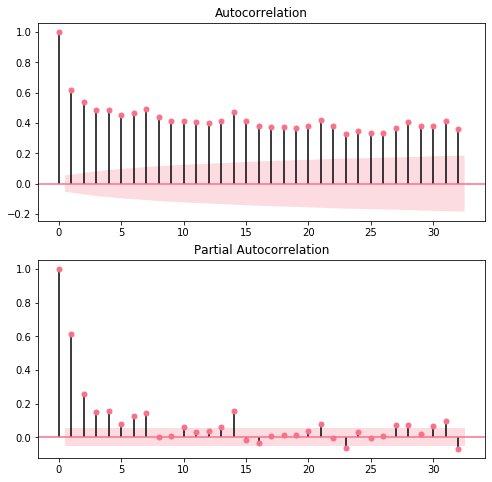

In [39]:
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 

fig, ax = plt.subplots(nrows=2,ncols=1)
plot_acf(train_data.values, ax = ax[0])
plot_pacf(train_data.values, ax = ax[1])
display()

In [40]:
diff_1=train_data.diff().dropna()
ADF_check(diff_1)

ADF Statistic: -10.729754110794438
p-value: 3.0008642226246783e-19
Critial Values:
1%, -3.4353288002925315
Critial Values:
5%, -2.863738738939919
Critial Values:
10%, -2.5679406189198177


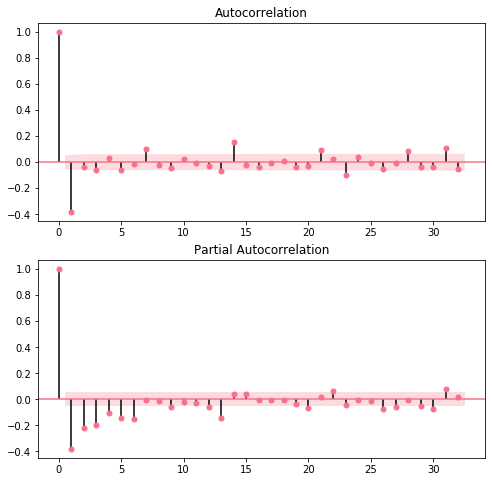

In [41]:
fig, ax = plt.subplots(nrows=2,ncols=1)
plot_acf(diff_1.values, ax = ax[0])
plot_pacf(diff_1.values, ax = ax[1])
display()

###**4.2.4 Parameter selection and model testing**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


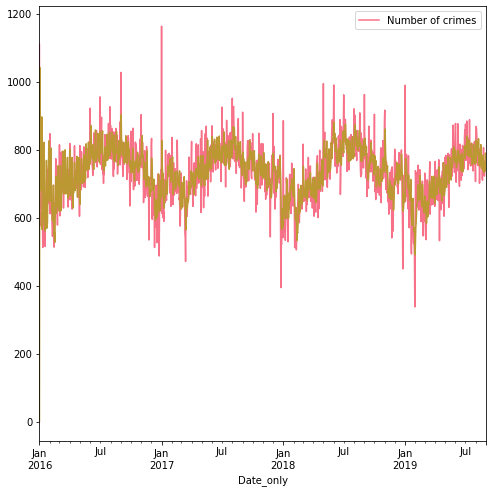

In [42]:
model=SARIMAX(train_data, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
result=model.fit()
fig, ax = plt.subplots()
ax = train_data.plot(ax=ax)
pred = result.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred.predicted_mean.plot(ax=ax)
display()

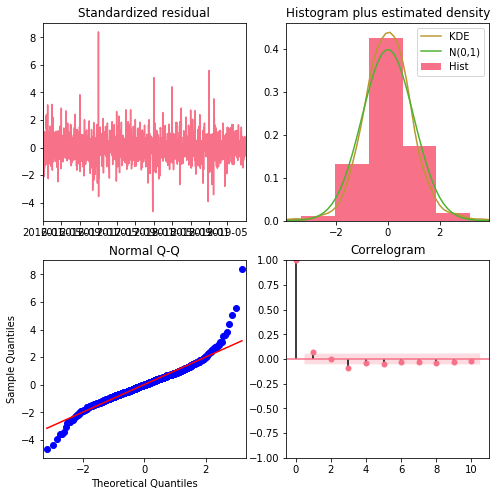

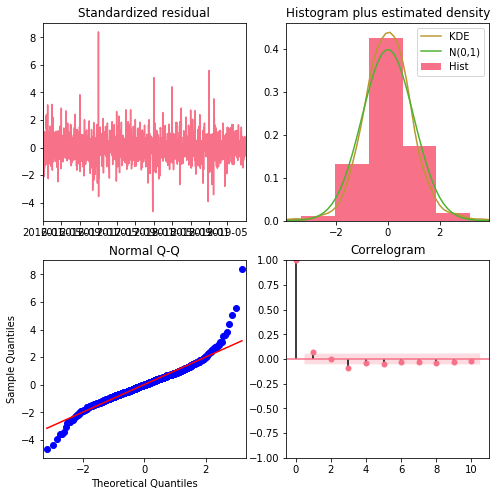

In [43]:
result.summary()
result.plot_diagnostics()

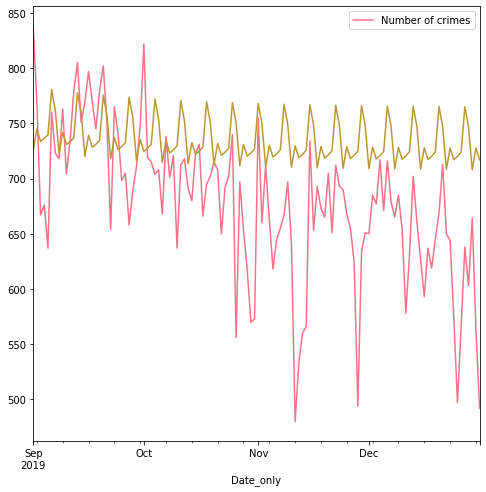

In [49]:
fig, ax = plt.subplots()
ax = test_data.plot(ax=ax)
pred = result.get_prediction(start=pd.to_datetime('2019-09-01'), end=pd.to_datetime('2019-12-31'), dynamic=False)
fig=pred.predicted_mean.plot()
display()

In [47]:
pred.predicted_mean

2019-09-01    725.856012
Freq: D, dtype: float64